In [37]:
%matplotlib inline 
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor  # 使用梯度提升回归器

In [2]:
from skopt import BayesSearchCV 
from skopt.space import Real, Integer
import matplotlib.pyplot as plt
import os
import pickle

In [3]:
from numpy.random import seed 
seed(200)

In [4]:
data = pd.read_excel('data/CO2_20250208.xlsx', sheet_name='CO2 solubility data')

In [5]:
data.head(8)

,No.,IL,x_CO2 (mol/kg sorbent),T (K),P (bar),IF1,IF2,IF3,IF4,IF5,...,IF35,IF36,IF37,IF38,IF39,IF40,IF41,IF42,IF43,IF44
0,1,[Bis(mim)C2][Gly]2,0.8504,313.15,0.1154,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,[Bis(mim)C2][Gly]2,1.1442,313.15,0.2692,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,[Bis(mim)C2][Gly]2,1.4535,313.15,0.5385,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,[Bis(mim)C2][Gly]2,2.3503,313.15,0.8462,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,[Bis(mim)C2][Gly]2,2.4895,313.15,1.3077,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,[Bis(mim)C2][Gly]2,2.5823,313.15,1.7308,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,[Bis(mim)C2][Gly]2,2.6132,313.15,2.0000,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,[Bis(mim)C2][Gly]2,2.6441,313.15,2.9615,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(data.shape)

(2500, 49)


In [7]:
exclude =['No.','IL']
y='x_CO2 (mol/kg sorbent)'
features = [var for var in data.columns if var not in exclude+[y]]
print(len(features), len(exclude))

46 2


In [8]:
data[features].info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 46 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   T (K)    2500 non-null   float64
 1   P (bar)  2500 non-null   float64
 2   IF1      2500 non-null   int64  
 3   IF2      2500 non-null   int64  
 4   IF3      2500 non-null   int64  
 5   IF4      2500 non-null   int64  
 6   IF5      2500 non-null   int64  
 7   IF6      2500 non-null   int64  
 8   IF7      2500 non-null   int64  
 9   IF8      2500 non-null   int64  
 10  IF9      2500 non-null   int64  
 11  IF10     2500 non-null   int64  
 12  IF11     2500 non-null   int64  
 13  IF12     2500 non-null   int64  
 14  IF13     2500 non-null   int64  
 15  IF14     2500 non-null   int64  
 16  IF15     2500 non-null   int64  
 17  IF16     2500 non-null   int64  
 18  IF17     2500 non-null   int64  
 19  IF18     2500 non-null   int64  
 20  IF19     2500 non-null   int64  
 21  IF20     2500 

In [9]:
single_var =[]
for var in features:
    print(var, "----",len(data[var].unique()),data[var].unique())
    if len(data[var].unique())==1:
        single_var.append(var)

T (K) ---- 48 [313.15 293.15 303.15 323.15 298.2  298.1  298.   298.3  288.15 298.15
 308.15 318.15 303.16 313.28 313.31 323.32 323.34 333.35 333.36 333.41
 353.55 353.18 295.15 283.1  323.1  348.1  348.2  310.15 333.15 343.15
 303.2  313.2  323.2  343.2  353.2  328.15 338.15 333.2  295.12 353.15
 296.15 373.15 393.15 308.   318.   328.   338.   283.15]
P (bar) ---- 1112 [0.1154 0.2692 0.5385 ... 0.234  0.239  0.419 ]
IF1 ---- 4 [ 2  1  0 10]
IF2 ---- 2 [0 1]
IF3 ---- 3 [0 2 1]
IF4 ---- 2 [0 1]
IF5 ---- 2 [0 1]
IF6 ---- 5 [ 0  1  2  3 10]
IF7 ---- 2 [0 1]
IF8 ---- 2 [0 1]
IF9 ---- 2 [0 1]
IF10 ---- 4 [0 3 2 1]
IF11 ---- 2 [0 1]
IF12 ---- 3 [0 2 1]
IF13 ---- 3 [0 1 2]
IF14 ---- 2 [0 1]
IF15 ---- 11 [ 2  4  5  3 20  1  6  8 12  7 40]
IF16 ---- 32 [  4   2   6   3   5   7   8   1  25  11  14   0  10  31  29  30  32  20
  26  21  12  24  22  33  17  13  16  28 295  58  57  56]
IF17 ---- 3 [0 1 2]
IF18 ---- 2 [0 1]
IF19 ---- 2 [0 1]
IF20 ---- 3 [0 2 1]
IF21 ---- 2 [0 1]
IF22 ---- 14 [ 6 12 

In [10]:
single_var

[]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data[features+exclude], data[y], test_size=0.2, random_state=512)
print(X_train.shape, X_test.shape)

(2000, 48) (500, 48)


In [12]:
use_feature = [var for var in features if var not in single_var]

In [14]:
# 标准化
sc = StandardScaler()
sc.fit(X_train[use_feature])

StandardScaler()

In [15]:
sc.mean_

array([3.10632380e+02, 1.83707045e+00, 4.51000000e-01, 5.00000000e-04,
       1.34500000e-01, 4.30000000e-02, 1.72500000e-01, 4.72000000e-01,
       2.15000000e-02, 9.00000000e-03, 9.00000000e-03, 4.50000000e-03,
       2.00000000e-03, 1.21000000e-01, 3.90000000e-02, 6.15000000e-02,
       3.44700000e+00, 1.29545000e+01, 3.31000000e-01, 4.00000000e-03,
       1.19000000e-01, 1.20000000e-01, 1.65000000e-02, 3.68900000e+00,
       8.30000000e-01, 1.65000000e-01, 4.60000000e-02, 1.65000000e-02,
       1.42000000e-01, 1.85000000e-02, 5.05500000e-01, 7.14000000e-01,
       6.55000000e-02, 5.85000000e-02, 5.15000000e-02, 9.80000000e-02,
       2.70000000e-02, 1.00000000e-03, 6.30000000e-02, 3.65000000e-02,
       1.65000000e-02, 6.00000000e-03, 3.35000000e-02, 1.00000000e-02,
       5.00000000e-04, 1.00000000e-03])

In [16]:
# 转换数据
X_train_scale = sc.transform(X_train[use_feature])
X_test_scale = sc.transform(X_test[use_feature])

In [17]:
X_train[use_feature].head(1)

,T (K),P (bar),IF1,IF2,IF3,IF4,IF5,IF6,IF7,IF8,...,IF35,IF36,IF37,IF38,IF39,IF40,IF41,IF42,IF43,IF44
268,288.15,3.5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X_train_scale[0:1]

array([[-1.25694529,  0.55835751,  0.86416626, -0.02236627, -0.32774696,
        -0.21197188, -0.45657334, -0.59221756, -0.14823092, -0.09529814,
        -0.09529814, -0.0488676 , -0.04476615, -0.30122345, -0.16708984,
        -0.25598848, -0.54581662, -0.43457622, -0.58748645, -0.06337243,
        -0.36752385, -0.36753834, -0.12952535, -0.19788331,  0.1258362 ,
        -0.34725301, -0.1627526 , -0.12952535, -0.30565141, -0.13729057,
         0.74892464,  0.3242047 , -0.26474697, -0.21789901, -0.23301557,
        -0.29231469, -0.166581  , -0.0316386 , -0.25929878, -0.19463484,
        -0.12952535, -0.0776931 , -0.18617505, -0.10050378, -0.02236627,
        -0.0316386 ]])

In [19]:
param_grid = {
   'n_estimators': np.arange(50, 500),  
    'max_depth': np.arange(5, 15),  
}

In [20]:
gbr = GradientBoostingRegressor(random_state=256)

In [21]:
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error'  
)

In [22]:
grid_search.fit(X_train_scale, y_train)

D:\ProgramData\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=256),
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111,...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
             scoring='neg_mean_squared_error')

In [23]:
best_params = grid_search.best_params_
print(f"最佳参数组合: {best_params}")

最佳参数组合: {'max_depth': 7, 'n_estimators': 499}


In [24]:
print("最优参数组合:", grid_search.best_params_)
print("最优模型分数（负均方误差）:", grid_search.best_score_)

最优参数组合: {'max_depth': 7, 'n_estimators': 499}
最优模型分数（负均方误差）: -0.1108321816321256


In [25]:
from mpl_toolkits.mplot3d import Axes3D

In [26]:
results = grid_search.cv_results_
mse_scores = -results['mean_test_score']  # 转换为正MSE
n_estimators = param_grid['n_estimators']
max_depth = param_grid['max_depth']

In [29]:
df_results = pd.DataFrame(results)
df_results['mean_test_mse'] = mse_scores  # 新增 MSE 列
print(df_results[['params', 'mean_test_mse']])

                                      params  mean_test_mse
0       {'max_depth': 5, 'n_estimators': 50}       0.291384
1       {'max_depth': 5, 'n_estimators': 51}       0.288645
2       {'max_depth': 5, 'n_estimators': 52}       0.284968
3       {'max_depth': 5, 'n_estimators': 53}       0.280652
4       {'max_depth': 5, 'n_estimators': 54}       0.278507
...                                      ...            ...
4495  {'max_depth': 14, 'n_estimators': 495}       0.215595
4496  {'max_depth': 14, 'n_estimators': 496}       0.215595
4497  {'max_depth': 14, 'n_estimators': 497}       0.215595
4498  {'max_depth': 14, 'n_estimators': 498}       0.215595
4499  {'max_depth': 14, 'n_estimators': 499}       0.215595

[4500 rows x 2 columns]


In [30]:
show_columns = [
    'params',  # 需要显示的参数列
    'mean_test_mse', 
]

In [31]:
print("\n所有参数组合的搜索结果：")
print(df_results[show_columns].sort_values(by='mean_test_mse'))


所有参数组合的搜索结果：
                                     params  mean_test_mse
1349  {'max_depth': 7, 'n_estimators': 499}       0.110832
1346  {'max_depth': 7, 'n_estimators': 496}       0.110856
1348  {'max_depth': 7, 'n_estimators': 498}       0.110858
1347  {'max_depth': 7, 'n_estimators': 497}       0.110868
1345  {'max_depth': 7, 'n_estimators': 495}       0.110870
...                                     ...            ...
4      {'max_depth': 5, 'n_estimators': 54}       0.278507
3      {'max_depth': 5, 'n_estimators': 53}       0.280652
2      {'max_depth': 5, 'n_estimators': 52}       0.284968
1      {'max_depth': 5, 'n_estimators': 51}       0.288645
0      {'max_depth': 5, 'n_estimators': 50}       0.291384

[4500 rows x 2 columns]


In [32]:
df_results.to_csv("grid_search_results.csv", index=False)
print("\n完整结果已保存到 grid_search_results.csv")


完整结果已保存到 grid_search_results.csv


In [33]:
X_grid, Y_grid = np.meshgrid(n_estimators, max_depth)
Z_grid = mse_scores.reshape(len(max_depth), len(n_estimators))  

<Figure size 640x480 with 0 Axes>

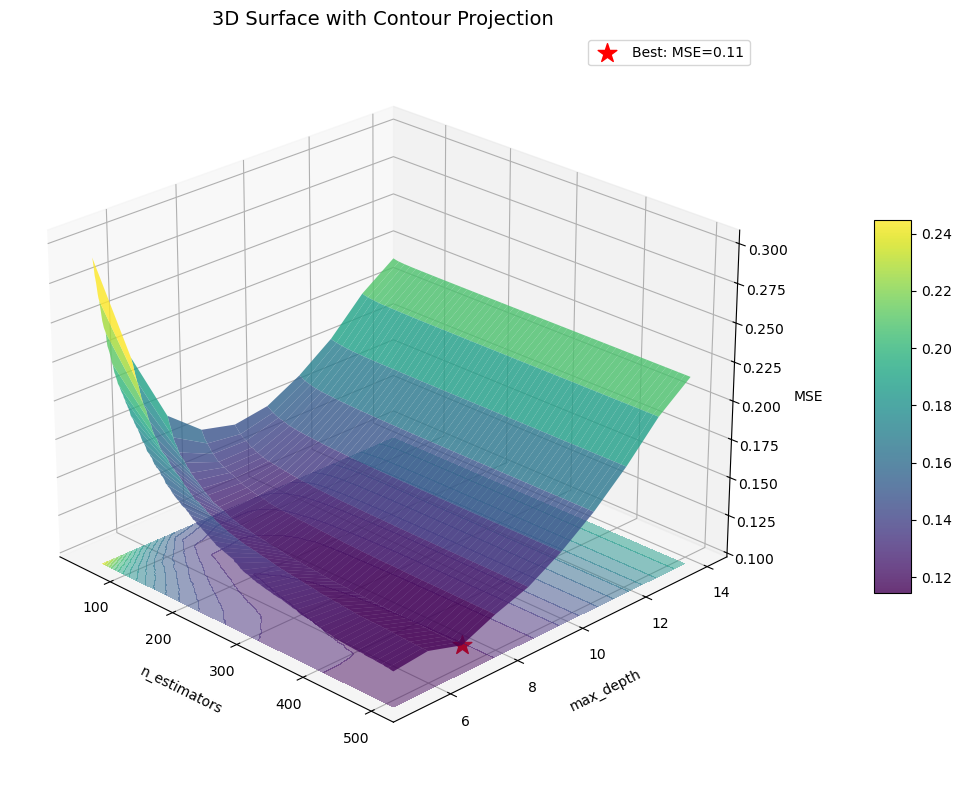

In [40]:
# 创建三维图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# --- 绘制3D曲面 ---
surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis', alpha=0.8)
ax.set_xlabel('n_estimators', labelpad=10)
ax.set_ylabel('max_depth', labelpad=10)
ax.set_zlabel('MSE', labelpad=10)
ax.set_title('3D Surface with Contour Projection', fontsize=14)


offset = np.min(Z_grid) - 0.1*(np.max(Z_grid)-np.min(Z_grid))  # 向下偏移避免重叠
cset = ax.contourf(X_grid, Y_grid, Z_grid, zdir='z', offset=offset, 
                   cmap='viridis', alpha=0.5, levels=20)

# 添加颜色条
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

# 标记最优参数点（三维空间）
best_n = grid_search.best_params_['n_estimators']
best_d = grid_search.best_params_['max_depth']
best_mse = np.min(Z_grid)
ax.scatter(best_n, best_d, best_mse, c='red', s=200, marker='*', 
           label=f'Best: MSE={best_mse:.2f}')

# 调整视角和显示
ax.view_init(elev=25, azim=-45)  # 调整视角角度
ax.legend()
plt.tight_layout()
plt.show()
plt.savefig('3d_plot.png')

In [42]:
plt.savefig('image_name.jpg')

In [43]:
best_model = grid_search.best_estimator_

train_y_pred = best_model.predict(X_train_scale)
test_y_pred = best_model.predict(X_test_scale)

In [72]:
def get_r2(y_true,y_pred):
    return metrics.r2_score(y_true,y_pred)

def get_rd(y_true,y_pred):
    return (np.array(y_pred)-np.array(y_true))/np.array(y_true)

def get_ard(y_true,y_pred):
    return abs(np.array(y_pred)-np.array(y_true))/np.array(y_true)

def get_aard(y_true,y_pred):
    assert len(y_true)==len(y_pred)
    rd = get_ard(y_true,y_pred)
    return np.mean(rd)
    
def get_mse(y_true, y_pred):
    return metrics.mean_squared_error(y_true, y_pred)

def get_rmse(y_true,y_pred):
    return math.sqrt(get_mse(y_true, y_pred))


def get_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)


def get_result(y_true, y_pred):
    r2 = get_r2(y_true,y_pred)
    rd = get_rd(y_true, y_pred)
    ard = get_ard(y_true, y_pred)
    aard = get_aard(y_true, y_pred)
    mse = get_mse(y_true, y_pred)
    rmse = get_rmse(y_true,y_pred)
    mae = get_mae(y_true,y_pred)
    print("R2:", r2)
    print('RD:', rd)
    print("ARD:", ard)
    print("AARD:", aard)
    print("mse:", mse)
    print("rmse:", rmse)
    print('mae:', mae)

In [81]:
# 评估函数
def get_result(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rd = (np.array(y_pred)-np.array(y_true))/np.array(y_true)
    aard = np.mean(rd)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"R²: {r2}, AARD: {aard}, MSE: {mse}, RMSE: {rmse}, MAE: {mae}")

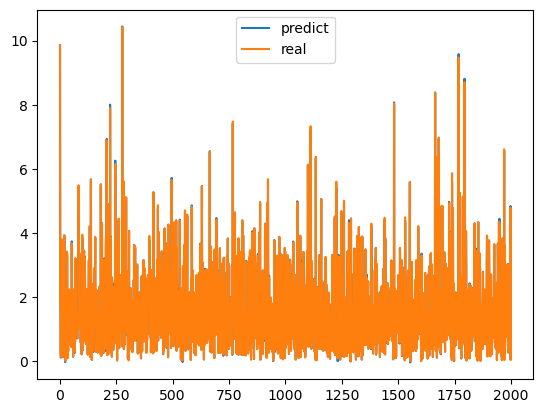

In [82]:
import matplotlib.pyplot as plt

r = len(y_train) + 1


plt.plot(np.arange(1,r), train_y_pred, label="predict")

plt.plot(np.arange(1,r), y_train, label="real")

plt.legend()
plt.show()

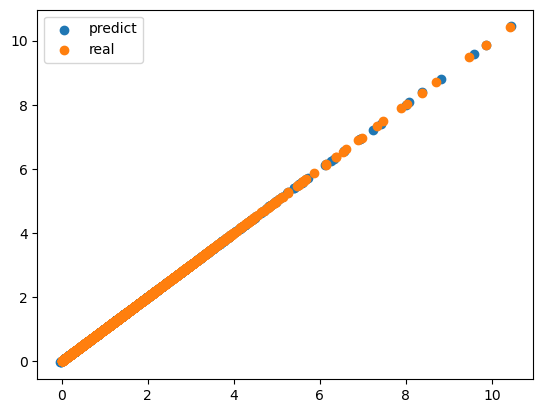

In [83]:
plt.scatter( train_y_pred, train_y_pred ,label="predict")
plt.scatter( y_train, y_train, label="real")

plt.legend()
plt.show()

In [84]:
# 训练集与测试集评估
print("train")
get_result(y_train, train_y_pred)
print("test")
get_result(y_test, test_y_pred )

train
R²: 0.9988579407236166, AARD: 0.005321628062188023, MSE: 0.0016713041489019856, RMSE: 0.040881586917608584, MAE: 0.024613250669990958
test
R²: 0.918621645547929, AARD: 0.10158203148308076, MSE: 0.11223310381217119, RMSE: 0.3350120950237039, MAE: 0.17626623074422712


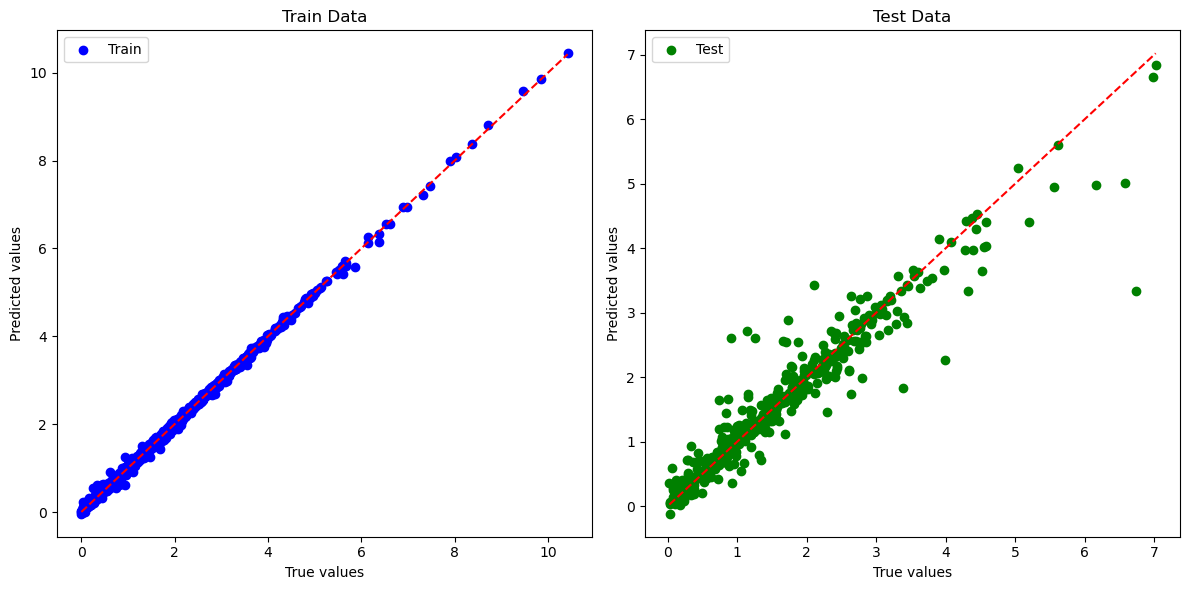

In [58]:
# 绘制预测图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, train_y_pred, color='blue', label="Train")
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Train Data")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, test_y_pred, color='green', label="Test")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Test Data")
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
plt.savefig('linaer.png')

In [60]:
# 保存模型
if not os.path.exists('result'):
    os.makedirs('result')

with open('result/best_model_gbr.pkl', 'wb') as file:
    pickle.dump(best_params, file)

with open('result/scaler.pkl', 'wb') as file:
    pickle.dump(sc, file)

In [61]:
# 保存结果
X_train['Predicted'] = train_y_pred
X_test['Predicted'] = test_y_pred

X_train.to_csv('result/X_train_result.csv', index=False)
X_test.to_csv('result/X_test_result.csv', index=False)

In [ ]:
#详细情况

In [65]:
train_RD = get_rd(y_train, train_y_pred)
train_ARD = get_ard(y_train, train_y_pred)
X_train['RD']=train_RD
X_train['ARD']= train_ARD
X_train['CO2'] = y_train
X_train['type'] ='train'

In [66]:
test_RD = get_rd(y_test, test_y_pred)
test_ARD = get_ard(y_test, test_y_pred)
X_test['RD']=test_RD
X_test['ARD']= test_ARD
X_test['CO2'] = y_test
X_test['type']='test'

In [68]:
import pickle
with open('result/best_model_gbr.pkl', 'wb') as file:
    pickle.dump(best_params, file)

with open('result/scaler.pkl', 'wb') as file:
    pickle.dump(sc, file)

In [69]:
X_train['pred']=train_y_pred
X_test['pred']=test_y_pred

In [71]:
X_train.to_csv('result/X_train_result_GBR_CO2.csv')
X_test.to_csv('result/X_test_result_GBR_CO2.csv')

In [ ]:
#代码完